In [8]:
import pickle 
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from collections import Counter
import torch_geometric
import GraphRicciCurvature

In [9]:
print(GraphRicciCurvature.__version__)

0.5.3.2


# Exploring Gene-Gene Network (GGNet)

In [7]:
with open('./Network/dataset_GGNet.pkl','rb') as f:
    data_dict_ggnet = pickle.load(f)
    f.close()

In [10]:
for key in data_dict_ggnet.keys():
    print(key, type(data_dict_ggnet[key]), len(data_dict_ggnet[key]) if type(data_dict_ggnet[key]) in [list] else data_dict_ggnet[key].shape)

feature <class 'torch.Tensor'> torch.Size([11183, 58])
node_name <class 'list'> 11183
edge_index <class 'torch.Tensor'> torch.Size([2, 1243976])
feature_name <class 'list'> 58
label <class 'torch.Tensor'> torch.Size([11183])
mask <class 'numpy.ndarray'> (11183,)


non-driver genes: 10475
driver genes: 708


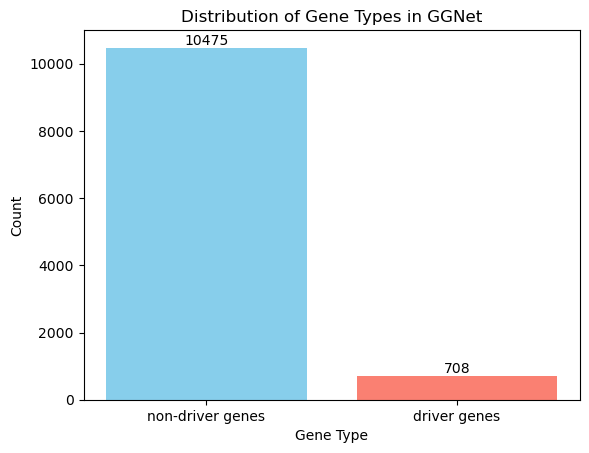

In [11]:
labels = data_dict_ggnet['label'].unique()
total0 = (data_dict_ggnet['label'] == labels[0]).sum().numpy()
total1 = (data_dict_ggnet['label'] == labels[1]).sum().numpy()

print(f"non-driver genes: {total0}")
print(f"driver genes: {total1}")

plt.bar(['non-driver genes', 'driver genes'], [total0, total1], color = ['skyblue','salmon'])
for i, v in enumerate([total0, total1]):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.xlabel('Gene Type')
plt.ylabel('Count')
plt.title('Distribution of Gene Types in GGNet')
plt.show()

## Feature distribution of nodes

In [13]:
features = data_dict_ggnet['feature'].numpy()
feature_names = data_dict_ggnet['feature_name']
nodes = data_dict_ggnet['node_name']

ggnet_feature_df = pd.DataFrame(features, columns = feature_names, index = nodes)
print(ggnet_feature_df.head())
print(ggnet_feature_df.columns)
print(ggnet_feature_df.shape)

          MF: KIRC  MF: BRCA  MF: READ  MF: PRAD  MF: STAD  MF: HNSC  \
PAF1      0.012837  0.005314  0.000000  0.022613  0.012897  0.016466   
AEBP2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
TBP       0.012819  0.005310  0.000000  0.000000  0.050806  0.010886   
RPS20     0.000000  0.000000  0.000000  0.000000  0.012781  0.000000   
SNRNP200  0.025649  0.031823  0.027725  0.067533  0.000000  0.005481   

          MF: LUAD  MF: THCA  MF: BLCA  MF: ESCA  ...  ohnolog  \
PAF1      0.040980  0.000000  0.030773  0.000000  ...      0.0   
AEBP2     0.000000  0.000000  0.000000  0.026986  ...      0.0   
TBP       0.000000  0.003513  0.030373  0.000000  ...      1.0   
RPS20     0.000000  0.000000  0.000000  0.000000  ...      0.0   
SNRNP200  0.059704  0.003604  0.030654  0.026980  ...      0.0   

          essentiality_percentage  essentiality_oneCellLine  \
PAF1                     0.488372                       1.0   
AEBP2                    0.058824           


=== Top 20 Most Connected Genes ===
      gene_name  node_index  degree
10480     CHMP6         423    7150
5657      RAD52         600    6428
5658     PRKAB1        1853    5858
6628     DNAJC1        9264    5706
2749       ADH5         307    5590
3499     POLR3A         285    5562
6616       TWF2        9261    5550
10483     UTP18         316    5468
3745      MUC21        6243    5206
6623      JADE2        9268    4716
10464     RPL24        1376    4474
2755      THOC1          65    4418
7991        LSS        1712    4282
128       BUD31        1640    4252
7907      RIPK1          46    4218
9619       BBS2         466    4188
10462    POLR2B        1149    4082
2754      STX17        1195    4070
6864      FGF20        4073    3786
131    ATP6V0A4        2784    3720

=== Connectivity Statistics ===
Mean degree: 222.48
Median degree: 122.00
Max degree: 7150
Min degree: 2
Standard deviation: 363.99


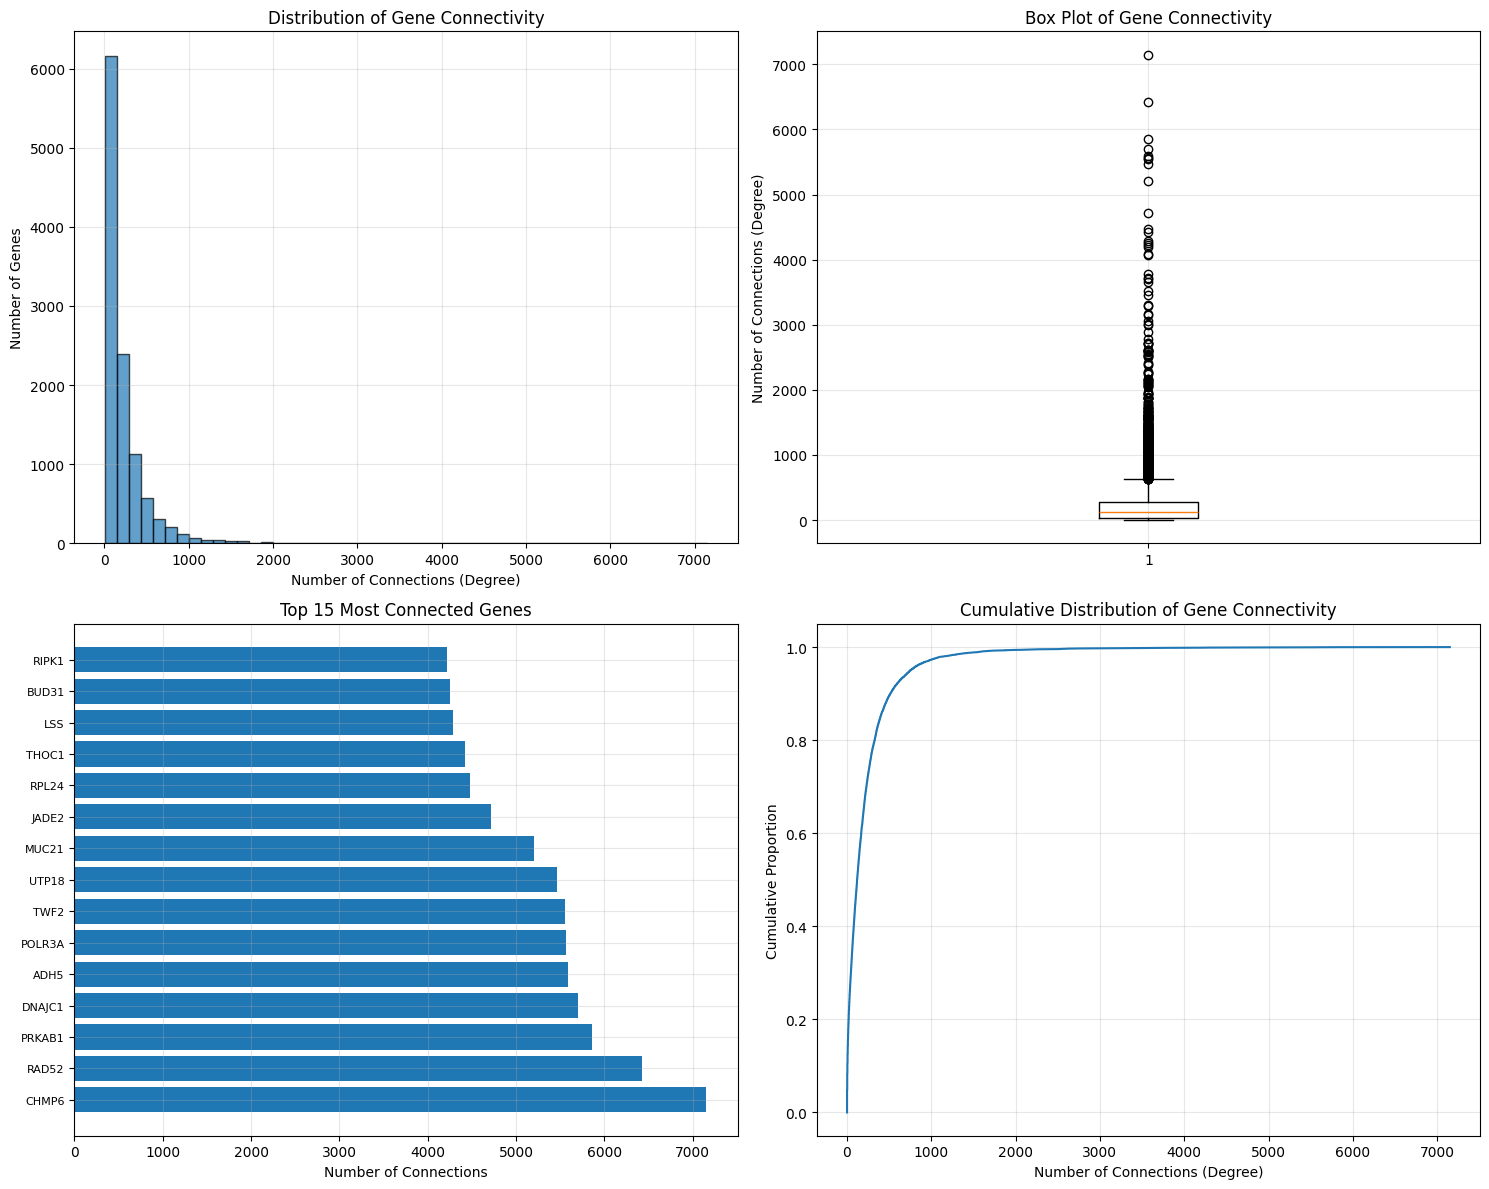

In [29]:
edge_index = data_dict_ggnet['edge_index'].numpy()
all_nodes = np.concatenate((edge_index[0], edge_index[1]))
node_degrees = Counter(all_nodes)
degree_data = []
for node_idx, degree in node_degrees.items():
    gene_name = nodes[node_idx] if node_idx < len(nodes) else f"Node_{node_idx}"
    degree_data.append({'gene_name': gene_name, 'node_index': node_idx, 'degree': degree})
degree_df = pd.DataFrame(degree_data)
degree_df = degree_df.sort_values('degree', ascending=False)

print("\n=== Top 20 Most Connected Genes ===")
print(degree_df.head(20))
print(f"\n=== Connectivity Statistics ===")
print(f"Mean degree: {degree_df['degree'].mean():.2f}")
print(f"Median degree: {degree_df['degree'].median():.2f}")
print(f"Max degree: {degree_df['degree'].max()}")
print(f"Min degree: {degree_df['degree'].min()}")
print(f"Standard deviation: {degree_df['degree'].std():.2f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Degree distribution histogram
axes[0,0].hist(degree_df['degree'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Number of Connections (Degree)')
axes[0,0].set_ylabel('Number of Genes')
axes[0,0].set_title('Distribution of Gene Connectivity')
axes[0,0].grid(True, alpha=0.3)

# 2. Box plot of degree distribution
axes[0,1].boxplot(degree_df['degree'])
axes[0,1].set_ylabel('Number of Connections (Degree)')
axes[0,1].set_title('Box Plot of Gene Connectivity')
axes[0,1].grid(True, alpha=0.3)

# 3. Top 15 most connected genes bar plot
top_genes = degree_df.head(15)
axes[1,0].barh(range(len(top_genes)), top_genes['degree'])
axes[1,0].set_yticks(range(len(top_genes)))
axes[1,0].set_yticklabels(top_genes['gene_name'], fontsize=8)
axes[1,0].set_xlabel('Number of Connections')
axes[1,0].set_title('Top 15 Most Connected Genes')
axes[1,0].grid(True, alpha=0.3)

# 4. Cumulative distribution
sorted_degrees = np.sort(degree_df['degree'])
cumulative_prop = np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)
axes[1,1].plot(sorted_degrees, cumulative_prop)
axes[1,1].set_xlabel('Number of Connections (Degree)')
axes[1,1].set_ylabel('Cumulative Proportion')
axes[1,1].set_title('Cumulative Distribution of Gene Connectivity')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
print(f"\n=== Hub Gene Analysis ===")
# Define hub genes as those with degree > mean + 2*std
hub_threshold = degree_df['degree'].mean() + 2 * degree_df['degree'].std()
hub_genes = degree_df[degree_df['degree'] > hub_threshold]
print(f"Hub threshold (mean + 2*std): {hub_threshold:.2f}")
print(f"Number of hub genes: {len(hub_genes)}")
print("\nHub genes:")
print(hub_genes)


=== Hub Gene Analysis ===
Hub threshold (mean + 2*std): 950.46
Number of hub genes: 344

Hub genes:
      gene_name  node_index  degree
10480     CHMP6         423    7150
5657      RAD52         600    6428
5658     PRKAB1        1853    5858
6628     DNAJC1        9264    5706
2749       ADH5         307    5590
...         ...         ...     ...
7903   ATP6V1B1         311     956
4916      RNF20        3694     954
6897       CD14        4559     952
820      B3GNT9       10438     952
2717     PNPLA4        6463     952

[344 rows x 3 columns]


# Exploring Pathway Network (PathNet)

In [6]:
with open('./Network/dataset_PathNet.pkl','rb') as f:
    data_dict_pathnet = pickle.load(f)
    f.close()

In [7]:
for key in data_dict_pathnet.keys():
    print(key, type(data_dict_pathnet[key]), len(data_dict_pathnet[key]) if type(data_dict_pathnet[key]) in [list] else data_dict_pathnet[key].shape)

feature <class 'torch.Tensor'> torch.Size([7695, 58])
node_name <class 'list'> 7695
edge_index <class 'torch.Tensor'> torch.Size([2, 185420])
feature_name <class 'list'> 58
label <class 'torch.Tensor'> torch.Size([7695])
mask <class 'numpy.ndarray'> (7695,)


non-driver genes: 7097
driver genes: 598


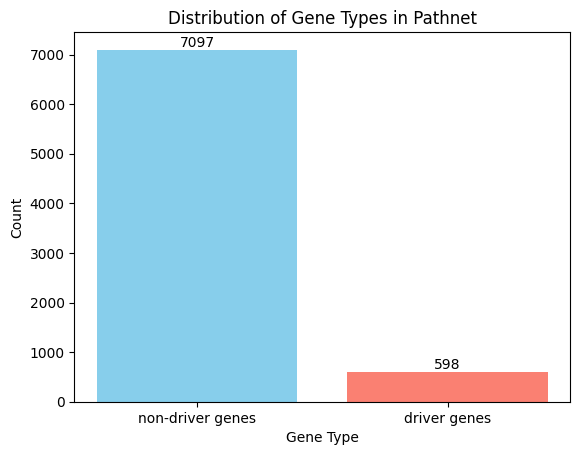

In [8]:
labels = data_dict_pathnet['label'].unique()
total0 = (data_dict_pathnet['label'] == labels[0]).sum().numpy()
total1 = (data_dict_pathnet['label'] == labels[1]).sum().numpy()

print(f"non-driver genes: {total0}")
print(f"driver genes: {total1}")

plt.bar(['non-driver genes', 'driver genes'], [total0, total1], color = ['skyblue','salmon'])
for i, v in enumerate([total0, total1]):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.xlabel('Gene Type')
plt.ylabel('Count')
plt.title('Distribution of Gene Types in Pathnet')
plt.show()

## Feature Distribution of nodes

In [9]:
features = data_dict_pathnet['feature'].numpy()
feature_names = data_dict_pathnet['feature_name']
nodes = data_dict_pathnet['node_name']

pathnet_feature_df = pd.DataFrame(features, columns = feature_names, index = nodes)
print(pathnet_feature_df.head())
print(pathnet_feature_df.shape)

        MF: KIRC  MF: BRCA  MF: READ  MF: PRAD  MF: STAD  MF: HNSC  MF: LUAD  \
TBP     0.012819  0.005310  0.000000  0.000000  0.050806  0.010886  0.000000   
RPS20   0.000000  0.000000  0.000000  0.000000  0.012781  0.000000  0.000000   
SUPT5H  0.025561  0.021198  0.054354  0.045414  0.036628  0.010862  0.000000   
GNB4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.020458   
MTA3    0.000000  0.005309  0.000000  0.000000  0.025049  0.010884  0.039699   

        MF: THCA  MF: BLCA  MF: ESCA  ...  ohnolog  essentiality_percentage  \
TBP     0.003513  0.030373       0.0  ...      1.0                 0.236994   
RPS20   0.000000  0.000000       0.0  ...      0.0                 0.618182   
SUPT5H  0.000000  0.030532       0.0  ...      0.0                 0.767442   
GNB4    0.000000  0.000000       0.0  ...      1.0                 0.011299   
MTA3    0.000000  0.000000       0.0  ...      1.0                 0.005650   

        essentiality_oneCellLine  expressed_


=== Top 20 Most Connected Genes ===
     gene_name  node_index  degree
3121     PSMC1        2012    1482
3122     HDAC2        2177    1386
3123     RPP25        1951    1380
1766   RPL26L1         337    1266
3477    MT-CYB        1169    1248
3852      PRF1         793    1238
3856     PTCD3        1010    1066
3855      GAB1        2046    1058
1779  PPARGC1A        1715    1022
3697     SLIT3        2210    1014
1774    ALYREF        1569     998
288       KLF4        3246     922
1826      CDH4        7238     892
287       STX4        1898     874
1827  SERPINA4        7239     858
3941      TRHR        4402     788
3260     ELMO3        2862     782
3698   HNRNPA0         697     782
2416  MAPKAPK2        2734     760
2410       FOS        1562     748

=== Connectivity Statistics ===
Mean degree: 48.19
Median degree: 18.00
Max degree: 1482
Min degree: 2
Standard deviation: 87.08


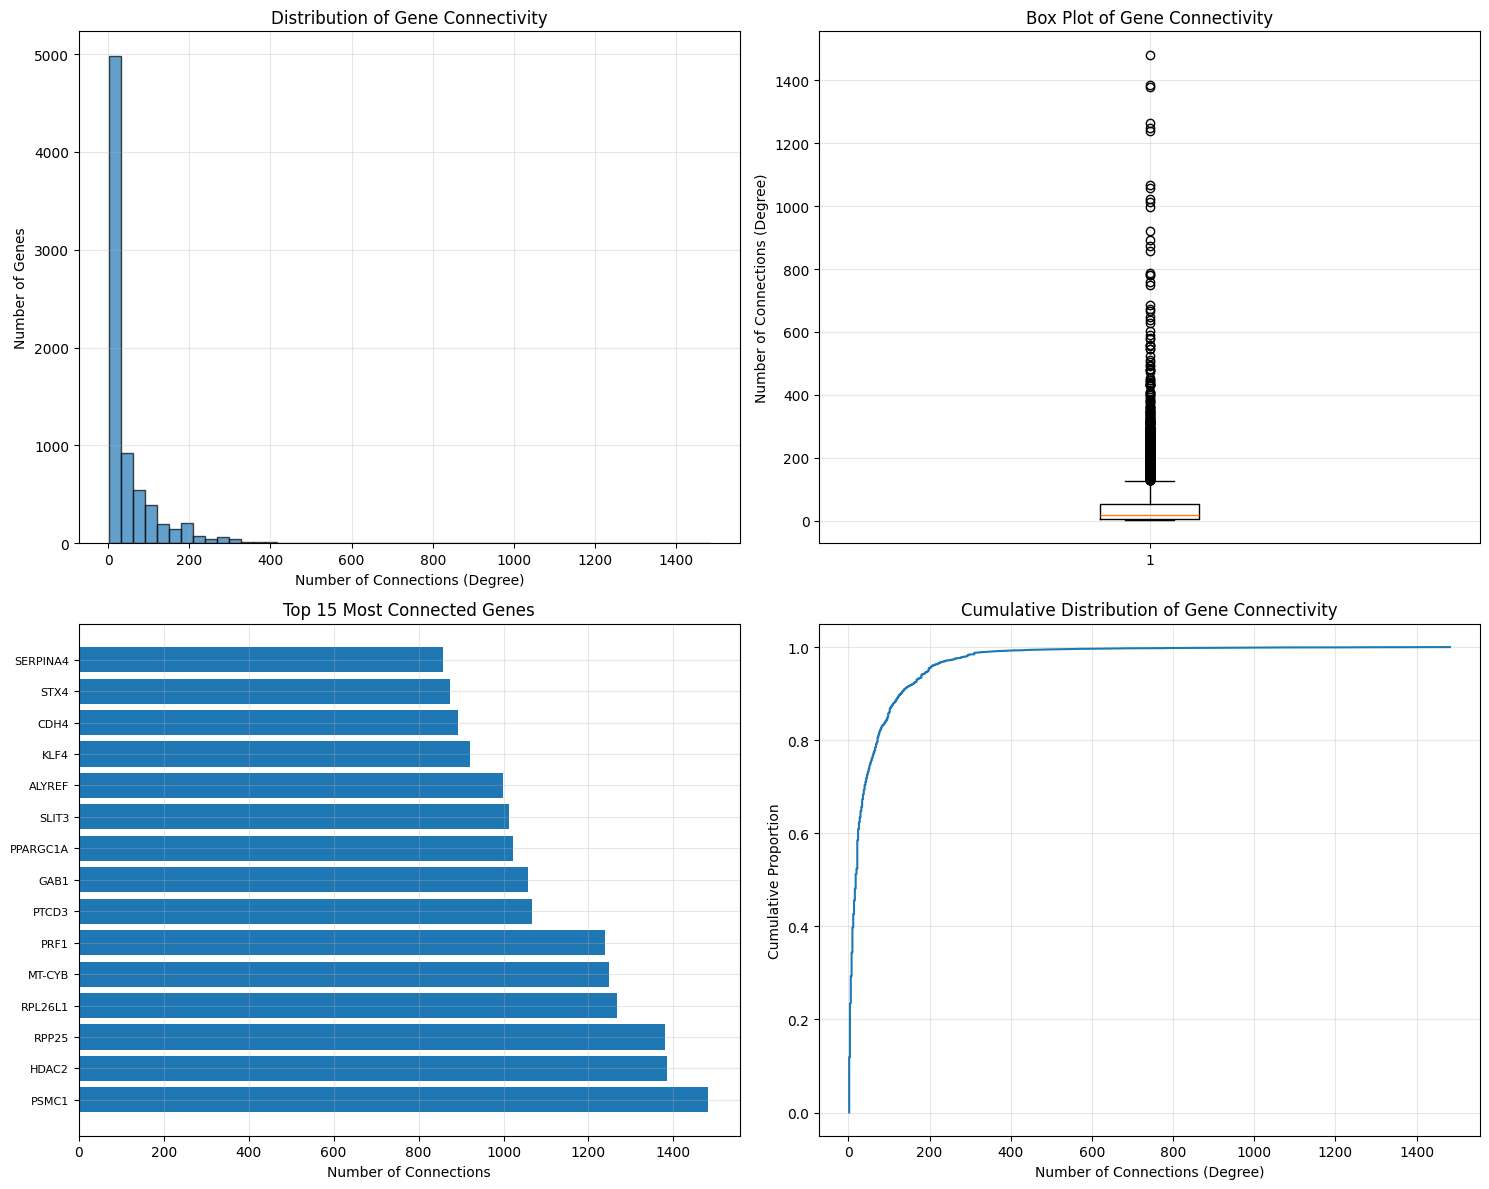

In [31]:
edge_index = data_dict_pathnet['edge_index'].numpy()
all_nodes = np.concatenate((edge_index[0], edge_index[1]))
node_degrees = Counter(all_nodes)
degree_data = []
for node_idx, degree in node_degrees.items():
    gene_name = nodes[node_idx] if node_idx < len(nodes) else f"Node_{node_idx}"
    degree_data.append({'gene_name': gene_name, 'node_index': node_idx, 'degree': degree})
degree_df = pd.DataFrame(degree_data)
degree_df = degree_df.sort_values('degree', ascending=False)

print("\n=== Top 20 Most Connected Genes ===")
print(degree_df.head(20))
print(f"\n=== Connectivity Statistics ===")
print(f"Mean degree: {degree_df['degree'].mean():.2f}")
print(f"Median degree: {degree_df['degree'].median():.2f}")
print(f"Max degree: {degree_df['degree'].max()}")
print(f"Min degree: {degree_df['degree'].min()}")
print(f"Standard deviation: {degree_df['degree'].std():.2f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Degree distribution histogram
axes[0,0].hist(degree_df['degree'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Number of Connections (Degree)')
axes[0,0].set_ylabel('Number of Genes')
axes[0,0].set_title('Distribution of Gene Connectivity')
axes[0,0].grid(True, alpha=0.3)

# 2. Box plot of degree distribution
axes[0,1].boxplot(degree_df['degree'])
axes[0,1].set_ylabel('Number of Connections (Degree)')
axes[0,1].set_title('Box Plot of Gene Connectivity')
axes[0,1].grid(True, alpha=0.3)

# 3. Top 15 most connected genes bar plot
top_genes = degree_df.head(15)
axes[1,0].barh(range(len(top_genes)), top_genes['degree'])
axes[1,0].set_yticks(range(len(top_genes)))
axes[1,0].set_yticklabels(top_genes['gene_name'], fontsize=8)
axes[1,0].set_xlabel('Number of Connections')
axes[1,0].set_title('Top 15 Most Connected Genes')
axes[1,0].grid(True, alpha=0.3)

# 4. Cumulative distribution
sorted_degrees = np.sort(degree_df['degree'])
cumulative_prop = np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)
axes[1,1].plot(sorted_degrees, cumulative_prop)
axes[1,1].set_xlabel('Number of Connections (Degree)')
axes[1,1].set_ylabel('Cumulative Proportion')
axes[1,1].set_title('Cumulative Distribution of Gene Connectivity')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Feature distribution of nodes

# Exploring Protein-Protein Interaction Network (PPINet)

In [10]:
with open('./Network/dataset_PPNet.pkl', 'rb') as f:
    data_dict_ppnet = pickle.load(f)
    f.close()

In [11]:
for key in data_dict_ppnet.keys():
    print(key, type(data_dict_ppnet[key]), len(data_dict_ppnet[key]) if type(data_dict_ppnet[key]) in [list] else data_dict_ppnet[key].shape)

feature <class 'torch.Tensor'> torch.Size([11395, 58])
node_name <class 'list'> 11395
edge_index <class 'torch.Tensor'> torch.Size([2, 571686])
feature_name <class 'list'> 58
label <class 'torch.Tensor'> torch.Size([11395])
mask <class 'numpy.ndarray'> (11395,)


non-driver genes: 10679
driver genes: 716


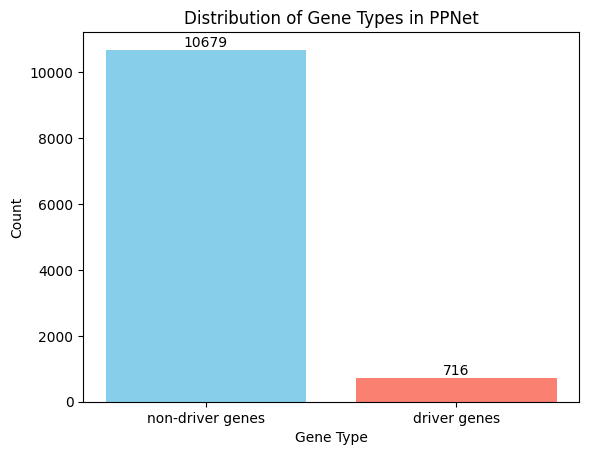

In [12]:
labels = data_dict_ppnet['label'].unique()
total0 = (data_dict_ppnet['label'] == labels[0]).sum().numpy()
total1 = (data_dict_ppnet['label'] == labels[1]).sum().numpy()

print(f"non-driver genes: {total0}")
print(f"driver genes: {total1}")

plt.bar(['non-driver genes', 'driver genes'], [total0, total1], color = ['skyblue','salmon'])
for i, v in enumerate([total0, total1]):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.xlabel('Gene Type')
plt.ylabel('Count')
plt.title('Distribution of Gene Types in PPNet')
plt.show()

## Feature distribution of nodes

In [13]:
features = data_dict_ppnet['feature'].numpy()
feature_names = data_dict_ppnet['feature_name']
nodes = data_dict_ppnet['node_name']

ppnet_feature_df = pd.DataFrame(features, columns = feature_names, index = nodes)
print(ppnet_feature_df.head())
print(ppnet_feature_df.shape)

          MF: KIRC  MF: BRCA  MF: READ  MF: PRAD  MF: STAD  MF: HNSC  \
PAF1      0.012837  0.005314  0.000000  0.022613  0.012897  0.016466   
AEBP2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
TBP       0.012819  0.005310  0.000000  0.000000  0.050806  0.010886   
RPS20     0.000000  0.000000  0.000000  0.000000  0.012781  0.000000   
SNRNP200  0.025649  0.031823  0.027725  0.067533  0.000000  0.005481   

          MF: LUAD  MF: THCA  MF: BLCA  MF: ESCA  ...  ohnolog  \
PAF1      0.040980  0.000000  0.030773  0.000000  ...      0.0   
AEBP2     0.000000  0.000000  0.000000  0.026986  ...      0.0   
TBP       0.000000  0.003513  0.030373  0.000000  ...      1.0   
RPS20     0.000000  0.000000  0.000000  0.000000  ...      0.0   
SNRNP200  0.059704  0.003604  0.030654  0.026980  ...      0.0   

          essentiality_percentage  essentiality_oneCellLine  \
PAF1                     0.488372                       1.0   
AEBP2                    0.058824           


=== Top 20 Most Connected Genes ===
     gene_name  node_index  degree
1384    RPS27A        1384    2384
938      UBA52         938    2286
1191       UBC        1191    2004
2457       UBB        2457    1982
403       GNB1         403    1444
1206     GNGT1        1206    1364
50         APP          50    1108
630      CDC5L         630    1082
833       GNG2         833    1044
1115      RBX1        1115    1040
1506      GNG5        1506     980
2078      GNG8        2078     978
1798     GNG10        1798     978
1337     GNG12        1337     978
1277     GNGT2        1277     978
547       GNG3         547     978
924       GNG4         924     978
806       GNB5         806     978
20        GNB3          20     978
3602      RAC1        3602     962

=== Connectivity Statistics ===
Mean degree: 100.34
Median degree: 30.00
Max degree: 2384
Min degree: 2
Standard deviation: 152.92


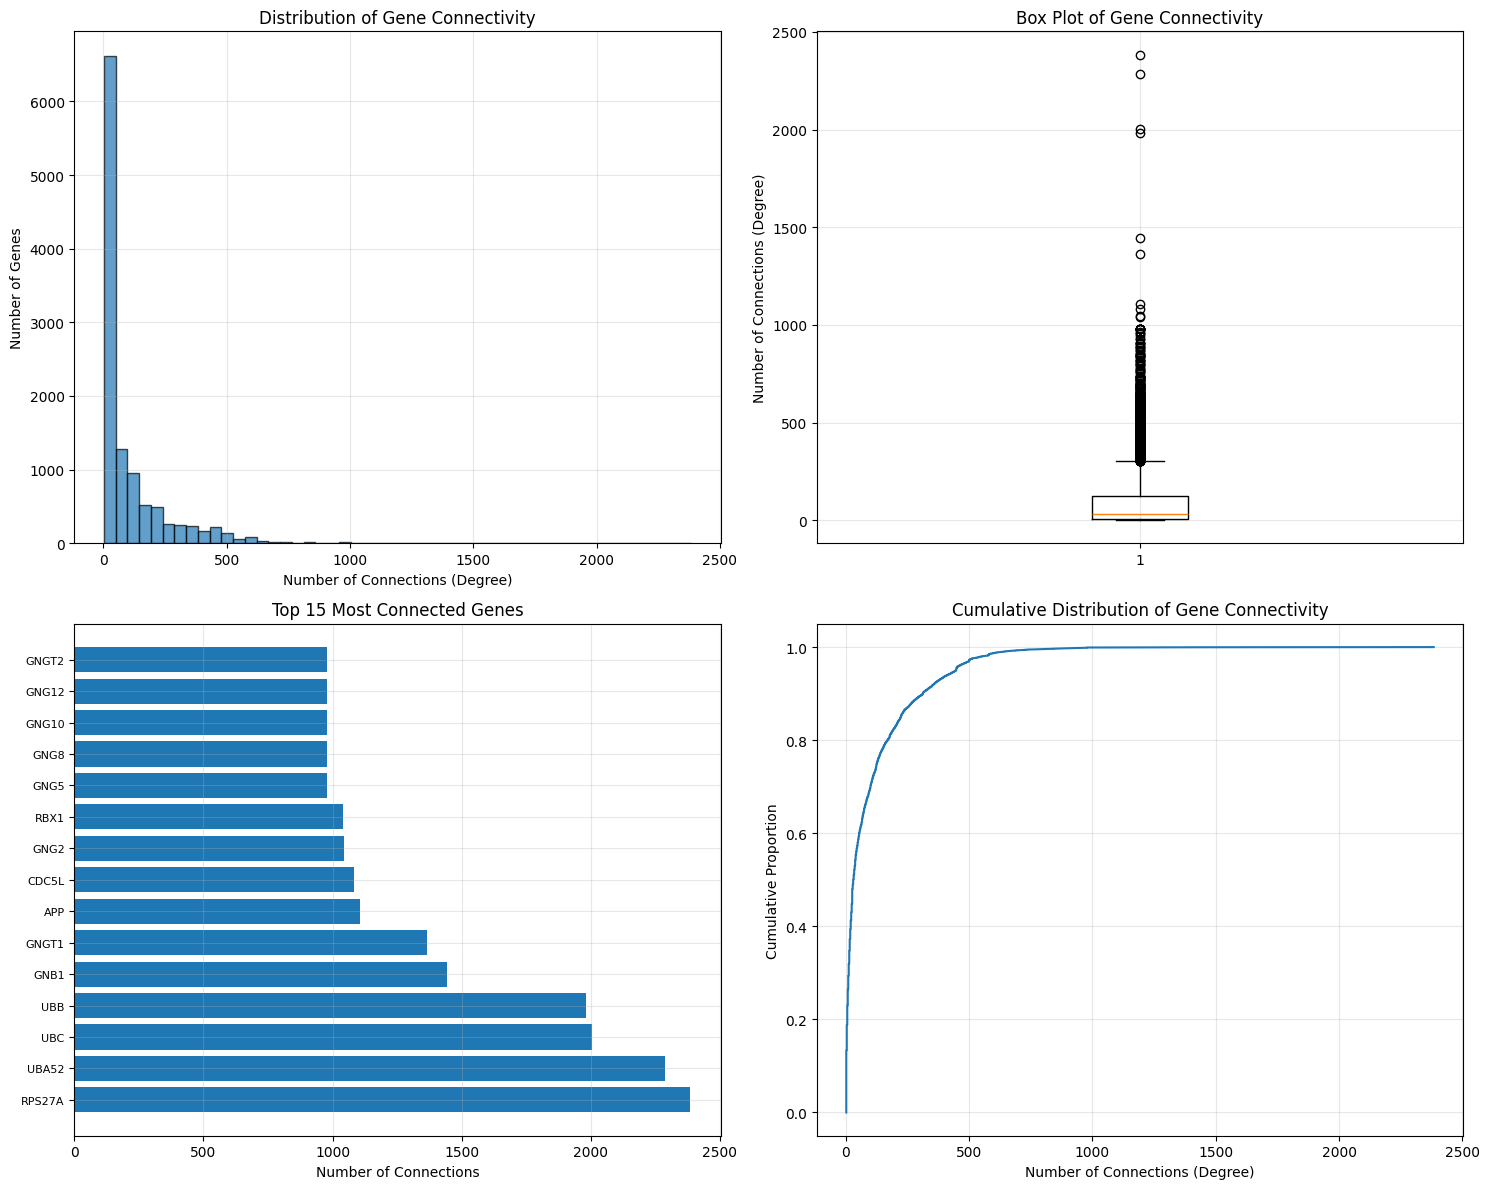

In [32]:
edge_index = data_dict_ppnet['edge_index'].numpy()
all_nodes = np.concatenate((edge_index[0], edge_index[1]))
node_degrees = Counter(all_nodes)
degree_data = []
for node_idx, degree in node_degrees.items():
    gene_name = nodes[node_idx] if node_idx < len(nodes) else f"Node_{node_idx}"
    degree_data.append({'gene_name': gene_name, 'node_index': node_idx, 'degree': degree})
degree_df = pd.DataFrame(degree_data)
degree_df = degree_df.sort_values('degree', ascending=False)

print("\n=== Top 20 Most Connected Genes ===")
print(degree_df.head(20))
print(f"\n=== Connectivity Statistics ===")
print(f"Mean degree: {degree_df['degree'].mean():.2f}")
print(f"Median degree: {degree_df['degree'].median():.2f}")
print(f"Max degree: {degree_df['degree'].max()}")
print(f"Min degree: {degree_df['degree'].min()}")
print(f"Standard deviation: {degree_df['degree'].std():.2f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Degree distribution histogram
axes[0,0].hist(degree_df['degree'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Number of Connections (Degree)')
axes[0,0].set_ylabel('Number of Genes')
axes[0,0].set_title('Distribution of Gene Connectivity')
axes[0,0].grid(True, alpha=0.3)

# 2. Box plot of degree distribution
axes[0,1].boxplot(degree_df['degree'])
axes[0,1].set_ylabel('Number of Connections (Degree)')
axes[0,1].set_title('Box Plot of Gene Connectivity')
axes[0,1].grid(True, alpha=0.3)

# 3. Top 15 most connected genes bar plot
top_genes = degree_df.head(15)
axes[1,0].barh(range(len(top_genes)), top_genes['degree'])
axes[1,0].set_yticks(range(len(top_genes)))
axes[1,0].set_yticklabels(top_genes['gene_name'], fontsize=8)
axes[1,0].set_xlabel('Number of Connections')
axes[1,0].set_title('Top 15 Most Connected Genes')
axes[1,0].grid(True, alpha=0.3)

# 4. Cumulative distribution
sorted_degrees = np.sort(degree_df['degree'])
cumulative_prop = np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)
axes[1,1].plot(sorted_degrees, cumulative_prop)
axes[1,1].set_xlabel('Number of Connections (Degree)')
axes[1,1].set_ylabel('Cumulative Proportion')
axes[1,1].set_title('Cumulative Distribution of Gene Connectivity')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()